
# Chapter 6


<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/phonchi/nsysu-math524/blob/main/static_files/presentations/Ch06-varselect-lab-zh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/phonchi/ISLP_labs/blob/main/Ch06-varselect-lab-zh.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>


In [ ]:
%load_ext cudf.pandas
%load_ext cuml.accel

In [2]:
%pip install ISLP

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 4.9 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=e20ce8535e5de0613bbab7032123fde350c7eb40c31647fd17b9ac364354e0f0
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


In [4]:
# 本 Notebook 使用的匯入（imports）
import itertools  # 組合/排列工具
import numpy as np  # 數值運算與陣列處理
import pandas as pd  # 資料表格與資料處理
import seaborn as sns  # 統計視覺化
import matplotlib.pyplot as plt  # 繪圖指令與樣式
from matplotlib.pyplot import subplots  # 建立子圖與繪圖版面
from tqdm.notebook import trange, tqdm  # 進度條顯示
from functools import partial  # 偏函式，便於固定部分參數
from ISLP import load_data  # ISLP 資料載入
from ISLP.models import (
    ModelSpec as MS, Stepwise, sklearn_selected, sklearn_selection_path
)  # 模型公式工具與逐步選擇/選擇路徑介面
import sklearn.linear_model as skl  # 線性模型（Lasso/Ridge/ElasticNet 等）
from sklearn.linear_model import LinearRegression  # 線性回歸（直接類別匯入）
import sklearn.model_selection as skm  # 驗證/搜尋工具（KFold/GridSearchCV 等）
from sklearn import metrics  # 評估指標（MSE、MAE、R^2 等）
from sklearn.model_selection import train_test_split  # 訓練/測試切分
from sklearn.preprocessing import StandardScaler  # 特徵標準化
from sklearn.pipeline import Pipeline  # 前處理 + 模型串接
from sklearn.decomposition import PCA  # 主成分分析 (PCA)
from sklearn.cross_decomposition import PLSRegression  # 偏最小平方 (PLS)
from mlxtend.feature_selection import SequentialFeatureSelector as SFS  # 逐步特徵選擇
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS  # 全域組合搜尋
from statsmodels.api import OLS, add_constant  # OLS 與常數項加入
from sklearn.metrics import mean_squared_error  # 均方誤差 (MSE)


# 實驗：線性模型與正則化方法

在本實驗中，我們實作本章討論的許多技術。我們在此頂層匯入一些函式庫。

我們必須重新啟動執行環境以使用新安裝的版本！

In [6]:
%matplotlib inline

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

## 子集選擇方法

這裡我們實作透過限制模型輸入變數子集來減少模型參數數量的方法。
**注意：目前我們無法輕易從 `ISLP` 獲得選定的特徵，因此建議使用自訂迴圈。**

我們將對 [`Hitters`](https://islp.readthedocs.io/en/latest/datasets/Hitters.html) 資料應用前向選擇方法。我們希望根據棒球員前一年的各種表現統計數據來預測其 `Salary`。

首先，我們注意到某些球員的 `Salary` 變數缺失。`np.isnan()` 函數可用於識別缺失觀測值。它返回與輸入向量相同形狀的陣列，對於任何缺失的元素為 `True`，非缺失元素為 `False`。然後可以使用 `sum()` 方法計算所有缺失元素的數量。

In [7]:
Hitters = load_data('Hitters')
Hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [8]:
np.isnan(Hitters['Salary']).sum()

np.int64(59)

我們看到 59 名球員的 `Salary` 缺失。資料表的 `dropna()` 方法會移除在任何變數中有缺失值的所有列（預設情況下 --- 請參見 `Hitters.dropna?`）。

In [9]:
Hitters = Hitters.dropna()
Hitters.shape

(263, 20)

### 使用 `ISLP` 進行前向選擇（補充）

我們首先使用基於 $C_p$ (6.2) 的前向選擇來選出最佳模型。這個評分標準不是 `scikit-learn` 的內建指標。因此我們自行定義一個函數來計算，並將其作為評分器使用。`scikit-learn` 預設會嘗試最大化評分，因此我們的評分函數計算負的 $C_p$ 統計量。

In [10]:
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n

我們需要估計殘差變異數 $\sigma^2$，它是上述評分函數的第一個參數。我們將擬合最大的模型（使用所有變數），並根據其 MSE 來估計 $\sigma^2$。

In [11]:
design = MS(Hitters.columns.drop('Salary')).fit(Hitters)
Y = np.array(Hitters['Salary'])
X = design.transform(Hitters)
sigma2 = OLS(Y,X).fit().scale #https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLSResults.html#statsmodels.regression.linear_model.OLSResults

`scikit-learn_selected()` 函數期望一個只有三個參數的評分器——即上述 `nCp()` 定義中的最後三個參數。我們使用在第 5.3.3 節首次見到的 `partial()` 函數來凍結第一個參數，使用我們對 $\sigma^2$ 的估計值。

In [12]:
neg_Cp = partial(nCp, sigma2)

現在我們可以使用 `neg_Cp()` 作為模型選擇的評分器。

除了評分之外，我們還需要指定搜尋策略。這透過 `ISLP.models` 套件中的 [`Stepwise()`](https://islp.readthedocs.io/en/latest/models/selection.html#forward-selection) 物件來完成。`Stepwise.first_peak()` 方法會執行前向逐步選擇，直到進一步新增變數不會改善評估分數為止。類似地，`Stepwise.fixed_steps()` 方法會執行固定步數的逐步搜尋。

In [13]:
strategy = Stepwise.first_peak(design,
                               direction='forward',
                               max_terms=len(design.terms))

現在我們使用前向選擇來擬合以 `Salary` 為結果變數的線性回歸模型。**為此，我們使用 `ISLP.models` 套件中的 `scikit-learn_selected()` 函數**。這個函數接受一個來自 `statsmodels` 的模型以及搜尋策略，並用其 `fit` 方法選擇模型。如果不指定 `scoring` 參數，評分預設為 MSE，因此所有 19 個變數都會被選中。

In [14]:
hitters_MSE = sklearn_selected(OLS,
                               strategy)
hitters_MSE.fit(Hitters, Y)
hitters_MSE.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

如預期所料，使用 `neg_Cp` 會產生較小的模型，只選擇了 10 個變數。

In [15]:
hitters_Cp = sklearn_selected(OLS,
                               strategy,
                               scoring=neg_Cp)
hitters_Cp.fit(Hitters, Y)
hitters_Cp.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

### 使用自訂迴圈進行前向與後向逐步選擇

上述程式碼並未嚴格遵循教科書。這裡是緊跟教科書的自訂實作。注意：我們在下面沒有考慮空模型。

In [16]:
def processSubset(X, Y, X_label):
    # Fit model on 特徵_set and calculate RSS
    X_model = X[X_label]
    # Add a constant (i.e., bias or intercept)
    X_model = add_constant(X_model)
    lin_reg = OLS(Y, X_model).fit()
    RSS = lin_reg.ssr
    return {'model': lin_reg, 'RSS': RSS}

In [17]:
def forward(X, Y, predictors):
    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]

    results = []

    for p in remaining_predictors:
        results.append(processSubset(X, Y, predictors+[p]))

    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)

    # Choose the model with the lowest RSS
    best_model = models.loc[models['RSS'].idxmin()]

    return best_model

def backward(X, Y, predictors):

    results = []

    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(X, Y, list(combo)))

    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)

    # Choose the model with the lowest RSS
    best_model = models.loc[models['RSS'].idxmin()]

    return best_model

In [18]:
models1 = pd.DataFrame(columns=['RSS', 'model'])

predictors = []

design = MS(Hitters.columns.drop('Salary')).fit(Hitters)
Y = np.array(Hitters['Salary'])
X = design.transform(Hitters)
X = X.drop('intercept', axis=1)

for i in range(1,len(X.columns)+1):
    models1.loc[i] = forward(X, Y, predictors)
    exog = models1.loc[i]['model'].model.exog_names.copy()
    exog.remove('const')
    predictors = exog
    print(i, predictors)

1 ['CRBI']
2 ['CRBI', 'Hits']
3 ['CRBI', 'Hits', 'PutOuts']
4 ['CRBI', 'Hits', 'PutOuts', 'Division[W]']
5 ['CRBI', 'Hits', 'PutOuts', 'Division[W]', 'AtBat']
6 ['CRBI', 'Hits', 'PutOuts', 'Division[W]', 'AtBat', 'Walks']
7 ['CRBI', 'Hits', 'PutOuts', 'Division[W]', 'AtBat', 'Walks', 'CWalks']
8 ['CRBI', 'Hits', 'PutOuts', 'Division[W]', 'AtBat', 'Walks', 'CWalks', 'CRuns']
9 ['CRBI', 'Hits', 'PutOuts', 'Division[W]', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat']
10 ['CRBI', 'Hits', 'PutOuts', 'Division[W]', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat', 'Assists']
11 ['CRBI', 'Hits', 'PutOuts', 'Division[W]', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat', 'Assists', 'League[N]']
12 ['CRBI', 'Hits', 'PutOuts', 'Division[W]', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat', 'Assists', 'League[N]', 'Runs']
13 ['CRBI', 'Hits', 'PutOuts', 'Division[W]', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat', 'Assists', 'League[N]', 'Runs', 'Errors']
14 ['CRBI', 'Hits', 'PutOuts', 'Division[W]', 'AtB

然後我們可以在第二階段使用 `AIC` 或 `BIC` 來選擇最佳模型

In [19]:
bic_f = []

for m in models1.model:
    bic_f.append(m.bic)

np.array(bic_f).argmin()

np.int64(5)

In [20]:
models2 = pd.DataFrame(columns=['RSS', 'model'], index = range(1, len(X.columns)))

predictors = X.columns # we start with full model Mp
models2.loc[len(predictors)] = processSubset(X, Y, predictors)

while(len(predictors) > 1):
    models2.loc[len(predictors)-1] = backward(X, Y, predictors)
    exog = models2.loc[len(predictors)-1]['model'].model.exog_names.copy()
    exog.remove('const')
    predictors = exog
    print(len(predictors), predictors)

/tmp/ipython-input-1733623811.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  models2.loc[len(predictors)] = processSubset(X, Y, predictors)


18 ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks', 'League[N]', 'Division[W]', 'PutOuts', 'Assists', 'Errors', 'NewLeague[N]']
17 ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks', 'League[N]', 'Division[W]', 'PutOuts', 'Assists', 'Errors', 'NewLeague[N]']
16 ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks', 'League[N]', 'Division[W]', 'PutOuts', 'Assists', 'Errors']
15 ['AtBat', 'Hits', 'HmRun', 'Runs', 'Walks', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks', 'League[N]', 'Division[W]', 'PutOuts', 'Assists', 'Errors']
14 ['AtBat', 'Hits', 'HmRun', 'Runs', 'Walks', 'CAtBat', 'CRuns', 'CRBI', 'CWalks', 'League[N]', 'Division[W]', 'PutOuts', 'Assists', 'Errors']
13 ['AtBat', 'Hits', 'Runs', 'Walks', 'CAtBat', 'CRuns', 'CRBI', 'CWalks', 'League[N]', 'Division[W]', 'PutOuts', 'Assists', 'Errors']
12 ['AtBat', 'Hits', 'Runs', 'Walks', 'CAtBat',

In [21]:
bic_b = []

for m in models2.model:
    bic_b.append(m.bic)

np.array(bic_b).argmin()

np.int64(7)

我們看到使用前向逐步選擇時，最佳的單變數模型只包含 `CRBI`，而最佳的雙變數模型額外包含 `Hits`。對於這個資料，前向選擇得到的最佳單變數到六變數模型和待會會提到的最佳子集選擇法都是相同的。然而，前向逐步選擇、後向逐步以及最佳子集選擇法所選擇所找到的最佳七變數模型都是不同的!

在 `scikit-learn` [https://scikit-learn.org/stable/modules/feature_selection.html](https://scikit-learn.org/stable/modules/feature_selection.html) 和 `mlxtend` [http://rasbt.github.io/mlxtend/api_subpackages/mlxtend.feature_selection/](http://rasbt.github.io/mlxtend/api_subpackages/mlxtend.feature_selection/) 中還有其他的特徵選擇方法可用。

In [22]:
lr = skl.LinearRegression()
sfs1 = SFS(lr,
          k_features=19,
          forward=True,
          floating=False,
          scoring='neg_mean_squared_error',
          cv=5)

sfs1.fit(X, Y)

SequentialFeatureSelector(estimator=LinearRegression(), k_features=(19, 19),
                          scoring='neg_mean_squared_error')

In [23]:
pd.DataFrame.from_dict(sfs1.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(11,)","[-69552.92336716877, -213009.92207213468, -118...",-142142.865462,"(CRBI,)",74428.969856,57908.267167,28954.133583
2,"(1, 11)","[-53798.49669675372, -163254.80704040316, -104...",-124277.839415,"(Hits, CRBI)",67031.533448,52152.810324,26076.405162
3,"(1, 11, 14)","[-62163.90514052798, -153941.8339340546, -9746...",-120082.156746,"(Hits, CRBI, Division[W])",59591.942127,46364.555526,23182.277763
4,"(1, 11, 14, 15)","[-65576.39003922703, -141278.46897398742, -825...",-117217.983933,"(Hits, CRBI, Division[W], PutOuts)",56263.230106,43774.704486,21887.352243
5,"(0, 1, 11, 14, 15)","[-64199.08545469608, -133171.50527159323, -836...",-114112.221253,"(AtBat, Hits, CRBI, Division[W], PutOuts)",54818.569746,42650.709646,21325.354823
6,"(0, 1, 5, 11, 14, 15)","[-60075.534122143225, -132306.39833204876, -76...",-110162.261438,"(AtBat, Hits, Walks, CRBI, Division[W], PutOuts)",57689.191967,44884.151259,22442.075629
7,"(0, 1, 3, 5, 11, 14, 15)","[-60330.259290065675, -132346.01741313483, -76...",-110553.231464,"(AtBat, Hits, Runs, Walks, CRBI, Division[W], ...",58252.099524,45322.112462,22661.056231
8,"(0, 1, 3, 5, 6, 11, 14, 15)","[-64303.54034551619, -130892.95408839494, -745...",-110934.554619,"(AtBat, Hits, Runs, Walks, Years, CRBI, Divisi...",57911.784581,45057.335875,22528.667937
9,"(0, 1, 3, 5, 6, 10, 11, 14, 15)","[-63508.04380015551, -137971.21159579084, -752...",-111236.70073,"(AtBat, Hits, Runs, Walks, Years, CRuns, CRBI,...",57344.878054,44616.263337,22308.131669
10,"(0, 1, 3, 5, 6, 10, 11, 12, 14, 15)","[-75371.33424690246, -128223.28240695967, -742...",-110021.54195,"(AtBat, Hits, Runs, Walks, Years, CRuns, CRBI,...",52372.497238,40747.582133,20373.791066


### 使用驗證集方法和交叉驗證選擇模型（使用 `ISLP`，補充）

作為使用 $C_p$ 的替代方案，我們可能會嘗試使用交叉驗證來選擇前向選擇中的模型。為此，我們需要一個方法來儲存前向選擇中找到的完整模型路徑，並允許對其中每個模型進行預測。**這可以通過 `ISLP.models` 中的 `scikit-learn_selection_path()` 估計器來完成。** `ISLP.models` 中的 `cross_val_predict()` 函數計算路徑上每個模型的交叉驗證預測值，我們可以用來評估路徑上的交叉驗證 MSE。

這裡我們定義一個策略來擬合完整的前向選擇路徑。雖然 `scikit-learn_selection_path()` 有各種參數選擇，我們這裡使用預設值，在每個步驟中基於 RSS 的最大減少來選擇模型。

In [24]:
strategy = Stepwise.fixed_steps(design,
                                len(design.terms),
                                direction='forward')
full_path = sklearn_selection_path(OLS, strategy)

現在我們在 `Hitters` 資料上擬合完整的前向選擇路徑並計算擬合值。

In [25]:
full_path.fit(Hitters, Y)
Yhat_in = full_path.predict(Hitters)
Yhat_in.shape

(263, 20)

這給了我們擬合值的陣列——總共 20 個步驟，包括空模型的擬合平均值——我們可以用來評估樣本內 MSE。如預期的那樣，樣本內 MSE 在我們採取的每一步都有改善，這表明我們必須使用驗證或交叉驗證方法來選擇步數。我們將 y 軸範圍固定在 50,000 到 250,000，以便與下面的交叉驗證和驗證集 MSE 以及其他方法（如 Ridge 回歸、Lasso、主成分回歸）進行比較。

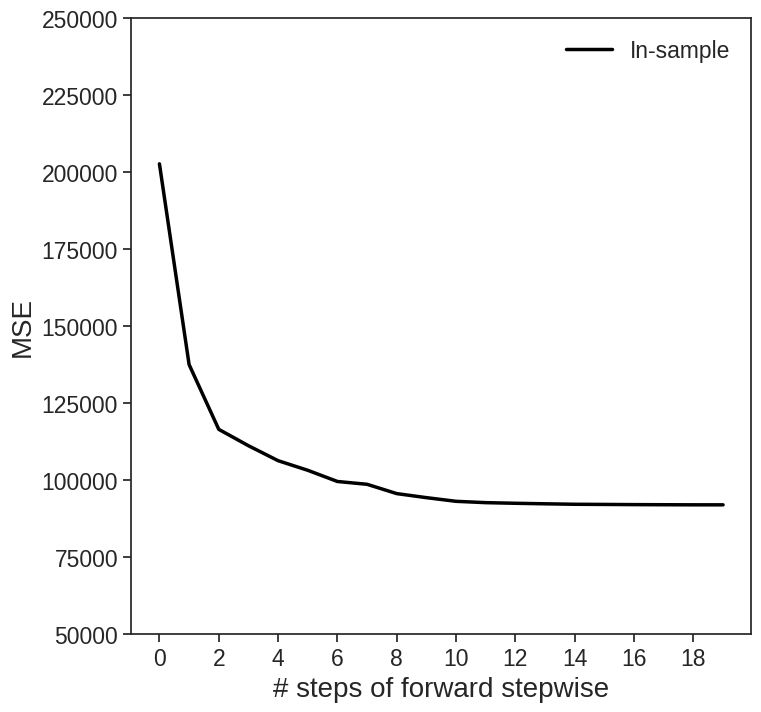

In [26]:
mse_fig, ax = subplots(figsize=(8,8))
insample_mse = ((Yhat_in - Y[:,None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps),
        insample_mse,
        'k', # color black
        label='In-sample')
ax.set_ylabel('MSE',
              fontsize=20)
ax.set_xlabel('# steps of forward stepwise',
              fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim([50000,250000]);

注意上面 `Y[:,None]` 中的 `None` 表達式。這為一維陣列 `Y` 添加了一個軸（維度），使其在從二維 `Yhat_in` 中減去時能夠被回收使用。

我們現在準備使用交叉驗證來估計沿著模型路徑的測試誤差。我們必須*僅使用訓練觀測值*來執行模型擬合的所有方面——包括變數選擇。因此，給定大小的哪個模型是最佳的決定必須僅使用每個訓練摺中的訓練觀測值來做出。這一點是微妙但重要的。如果使用完整資料集在每個步驟選擇最佳子集，那麼我們獲得的驗證集誤差和交叉驗證誤差將不是測試誤差的準確估計。

我們現在使用 5 摺交叉驗證計算交叉驗證的預測值。

In [27]:
K = 5
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)
Yhat_cv = skm.cross_val_predict(full_path,
                                Hitters,
                                Y,
                                cv=kfold)
Yhat_cv.shape

(263, 20)

預測矩陣 `Yhat_cv` 與 `Yhat_in` 的形狀相同；差異在於每一行中的預測（對應特定樣本索引）都是從不包含該行的訓練摺上擬合的模型做出的。

在路徑上的每個模型處，我們計算每個交叉驗證摺中的 MSE。這些我們會平均得到平均 MSE，也可以使用個別值來計算平均值標準誤差的粗略估計。**這個估計是粗略的，因為五個誤差估計是基於重疊的訓練集，因此不是獨立的。**因此我們必須知道每個交叉驗證分割的測試索引。這可以通過使用 `kfold` 的 `split()` 方法找到。因為我們上面固定了隨機狀態，每當我們分割任何與 $Y$ 相同行數的陣列時，我們都會恢復相同的訓練和測試索引，不過我們在下面簡單地忽略訓練索引。

In [28]:
cv_mse = []
for train_idx, test_idx in kfold.split(Y):
    errors = (Yhat_cv[test_idx] - Y[test_idx,None])**2
    cv_mse.append(errors.mean(0)) # column means
cv_mse = np.array(cv_mse).T
cv_mse.shape

(20, 5)

我們現在將交叉驗證誤差估計加入到我們的 MSE 圖中。我們包括五摺的平均誤差和平均值標準誤差的估計。

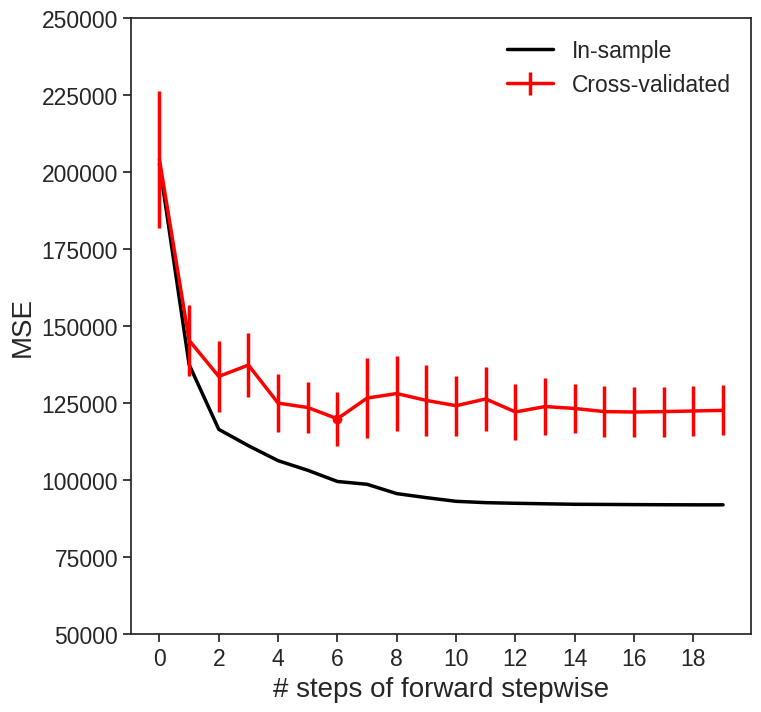

In [29]:
ax.errorbar(np.arange(n_steps),
            cv_mse.mean(1),
            cv_mse.std(1) / np.sqrt(K),
            label='Cross-validated',
            c='r') # color red
ax.plot(cv_mse.mean(1).argmin(), cv_mse.mean(1).min(), 'or', label='_nolegend_')
ax.set_ylim([50000,250000])
ax.legend()
mse_fig

要使用驗證集方法重複上述過程，我們只需將我們的 `cv` 參數更改為驗證集：將資料隨機分割為測試和訓練的一次分割。我們選擇 20% 的測試大小，類似於 5 摺交叉驗證中每個測試集的大小。

In [30]:
validation = skm.ShuffleSplit(n_splits=1,
                              test_size=0.2,
                              random_state=0)
for train_idx, test_idx in validation.split(Y):
    full_path.fit(Hitters.iloc[train_idx],
                  Y[train_idx])
    Yhat_val = full_path.predict(Hitters.iloc[test_idx])
    errors = (Yhat_val - Y[test_idx,None])**2
    validation_mse = errors.mean(0)

與樣本內 MSE 情況一樣，驗證集方法不提供標準誤差。

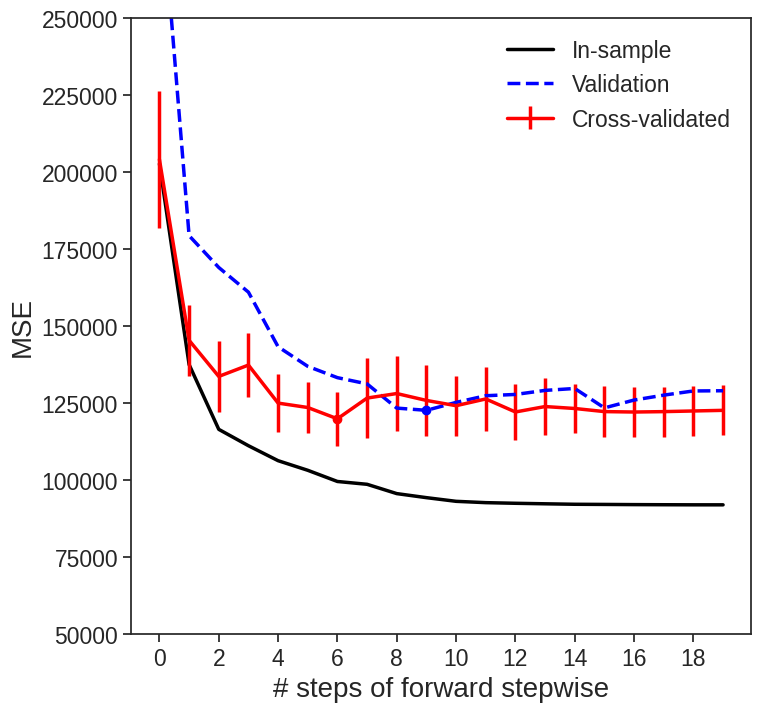

In [31]:
ax.plot(np.arange(n_steps),
        validation_mse,
        'b--', # color blue, broken line
        label='Validation')
ax.plot(validation_mse.argmin(), validation_mse.min(), 'ob', label='_nolegend_')
ax.set_xticks(np.arange(n_steps)[::2])
ax.set_ylim([50000,250000])
ax.legend()
mse_fig

### 使用自訂迴圈的驗證集方法和交叉驗證選擇模型

事實上我們可以在第二階段使用 AIC、BIC 和調整後的 $R^2$ 在一組不同大小的模型中進行選擇。我們現在將考慮如何使用自訂迴圈的驗證集和交叉驗證方法來做到這一點。

為了讓這些方法產生測試誤差的準確估計，我們必須僅使用訓練觀測值來執行模型擬合的所有方面——包括變數選擇。因此，給定大小的哪個模型是最佳的決定必須僅使用訓練觀測值來做出。這一點是微妙但重要的。如果使用完整資料集在每個最佳子集選擇步驟中，那麼我們獲得的驗證集誤差和交叉驗證誤差將不是測試誤差的準確估計。

In [32]:
def processSubset(X_train, y_train, X_test, y_test, X_label):
    # Fit model on 特徵_set and calculate RSS
    X_model = X_train[X_label]
    # Add a constant (i.e., bias or intercept)
    X_model = add_constant(X_model)
    lin_reg = OLS(y_train, X_model).fit()
    RSS = ((lin_reg.predict(add_constant(X_test[X_label])) - y_test) ** 2).sum() #on test set
    return {'model': lin_reg, 'RSS': RSS}

In [33]:
def forward(X_train, y_train, X_test, y_test, predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X_train.columns if p not in predictors]

    results = []

    for p in remaining_predictors:
        results.append(processSubset(X_train, y_train, X_test, y_test, predictors+[p]))

    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]

    # Return the best model, along with some other useful information about the model
    return best_model

In [34]:
design = MS(Hitters.columns.drop('Salary')).fit(Hitters)
Y = np.array(Hitters['Salary'])
X = design.transform(Hitters)
X = X.drop('intercept', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [35]:
models_test = pd.DataFrame(columns=['RSS', 'model'])

predictors = []

for i in range(1,len(X.columns)+1):
    models_test.loc[i] = forward(X_train, y_train, X_test, y_test, predictors)
    exog = models_test.loc[i]['model'].model.exog_names.copy()
    exog.remove('const')
    predictors = exog
    print(i, predictors)

1 ['CRBI']
2 ['CRBI', 'PutOuts']
3 ['CRBI', 'PutOuts', 'Division[W]']
4 ['CRBI', 'PutOuts', 'Division[W]', 'Years']
5 ['CRBI', 'PutOuts', 'Division[W]', 'Years', 'Errors']
6 ['CRBI', 'PutOuts', 'Division[W]', 'Years', 'Errors', 'CWalks']
7 ['CRBI', 'PutOuts', 'Division[W]', 'Years', 'Errors', 'CWalks', 'NewLeague[N]']
8 ['CRBI', 'PutOuts', 'Division[W]', 'Years', 'Errors', 'CWalks', 'NewLeague[N]', 'League[N]']
9 ['CRBI', 'PutOuts', 'Division[W]', 'Years', 'Errors', 'CWalks', 'NewLeague[N]', 'League[N]', 'CRuns']
10 ['CRBI', 'PutOuts', 'Division[W]', 'Years', 'Errors', 'CWalks', 'NewLeague[N]', 'League[N]', 'CRuns', 'CAtBat']
11 ['CRBI', 'PutOuts', 'Division[W]', 'Years', 'Errors', 'CWalks', 'NewLeague[N]', 'League[N]', 'CRuns', 'CAtBat', 'CHits']
12 ['CRBI', 'PutOuts', 'Division[W]', 'Years', 'Errors', 'CWalks', 'NewLeague[N]', 'League[N]', 'CRuns', 'CAtBat', 'CHits', 'CHmRun']
13 ['CRBI', 'PutOuts', 'Division[W]', 'Years', 'Errors', 'CWalks', 'NewLeague[N]', 'League[N]', 'CRuns', 'CA

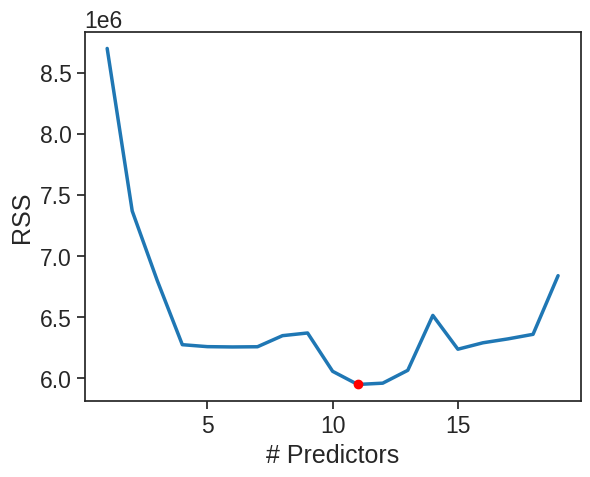

In [36]:
sns.lineplot(x=range(1,20), y=models_test['RSS'])
plt.xlabel('# Predictors')
plt.ylabel('RSS')
plt.plot(models_test['RSS'].astype(np.float64).argmin()+1, models_test['RSS'].min(), 'or');

現在我們知道要尋找什麼，讓我們在完整資料集上執行前向選擇並選擇最佳的 11 預測變數模型。重要的是我們使用*完整資料集*以獲得更準確的係數估計。**注意：我們在完整資料集上執行前向選擇並選擇最佳的 11 預測變數模型，而不是簡單地使用從訓練集獲得的預測變數，因為完整資料集上的最佳 11 預測變數模型可能與訓練集上的對應模型不同。**

In [37]:
models_full = pd.DataFrame(columns=['RSS', 'model'])

predictors = []

for i in range(1,12):
    models_full.loc[i] = forward(X, Y, X, Y, predictors) #use full dataset
    exog = models_full.loc[i]['model'].model.exog_names.copy()
    exog.remove('const')
    predictors = exog
    print(i, predictors)

1 ['CRBI']
2 ['CRBI', 'Hits']
3 ['CRBI', 'Hits', 'PutOuts']
4 ['CRBI', 'Hits', 'PutOuts', 'Division[W]']
5 ['CRBI', 'Hits', 'PutOuts', 'Division[W]', 'AtBat']
6 ['CRBI', 'Hits', 'PutOuts', 'Division[W]', 'AtBat', 'Walks']
7 ['CRBI', 'Hits', 'PutOuts', 'Division[W]', 'AtBat', 'Walks', 'CWalks']
8 ['CRBI', 'Hits', 'PutOuts', 'Division[W]', 'AtBat', 'Walks', 'CWalks', 'CRuns']
9 ['CRBI', 'Hits', 'PutOuts', 'Division[W]', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat']
10 ['CRBI', 'Hits', 'PutOuts', 'Division[W]', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat', 'Assists']
11 ['CRBI', 'Hits', 'PutOuts', 'Division[W]', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat', 'Assists', 'League[N]']


In [38]:
print(models_test.loc[11, 'model'].model.exog_names)
print(models_full.loc[11, 'model'].model.exog_names) # we will use this one as our final model!

['const', 'CRBI', 'PutOuts', 'Division[W]', 'Years', 'Errors', 'CWalks', 'NewLeague[N]', 'League[N]', 'CRuns', 'CAtBat', 'CHits']
['const', 'CRBI', 'Hits', 'PutOuts', 'Division[W]', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat', 'Assists', 'League[N]']


現在讓我們嘗試使用交叉驗證在不同大小的模型中進行選擇。這種方法有些複雜，因為我們必須在 $k$ 個訓練集中的每一個都執行前向選擇。儘管如此，我們看到憑藉其巧妙的子集語法，`python` 使這項工作變得相當容易。首先，我們創建一個向量，將每個觀測值分配給 $k = 5$ 摺中的一個，並創建一個 DataFrame 來儲存結果：

In [39]:
k = 5
kf = skm.KFold(n_splits=k, shuffle=True, random_state=0)

In [40]:
# Create a DataFrame to store the results of our upcoming calculations
cv_errors = pd.DataFrame(columns=range(1,k+1), index=range(1,20))
cv_errors = cv_errors.fillna(0)

models_cv = pd.DataFrame(columns=["RSS", "model"])

j = 0
# Outer loop iterates over all folds
for train_index, test_index in tqdm(kf.split(X)):
    j = j+1
    # Reset predictors
    predictors = []

    X_train2, X_test2 = X.iloc[train_index], X.iloc[test_index]
    y_train2, y_test2 = Y[train_index], Y[test_index]

    # Inner loop iterates over each size i
    for i in range(1,len(X.columns)+1):

        # The perform forward selection on the full dataset minus the jth fold, test on jth fold
        models_cv.loc[i] = forward(X_train2, y_train2, X_test2, y_test2, predictors)

        # Save the cross-validated error for this fold
        cv_errors.at[i, j] = models_cv.loc[i, "RSS"]

        exog = models_cv.loc[i, 'model'].model.exog_names.copy()
        exog.remove('const')
        predictors = exog

/tmp/ipython-input-1550520025.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cv_errors = cv_errors.fillna(0)


0it [00:00, ?it/s]

/tmp/ipython-input-1550520025.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '8697237.798997663' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cv_errors.at[i, j] = models_cv.loc[i, "RSS"]
/tmp/ipython-input-1550520025.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '7799150.816764267' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cv_errors.at[i, j] = models_cv.loc[i, "RSS"]
/tmp/ipython-input-1550520025.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5883432.344643183' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cv_errors.at[i, j] = models_cv.loc[i, "RSS"]
/tmp/ipython-input-1550520025.py:24: Future

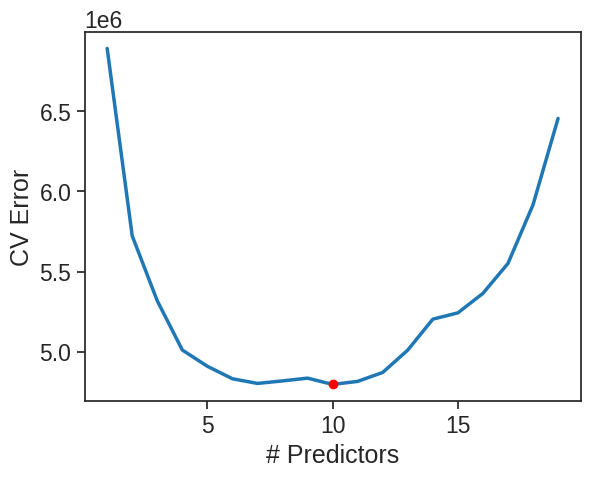

In [41]:
cv_mean = cv_errors.apply(np.mean, axis=1)

sns.lineplot(x=range(1,20), y=cv_mean)
plt.xlabel('# Predictors')
plt.ylabel('CV Error')
plt.plot(cv_mean.argmin()+1, cv_mean.min(), "or");

交叉驗證建議 10 預測變數模型是最佳模型。我們現在在完整資料集上執行前向選擇以獲得 10 變數模型。

In [42]:
models_full = pd.DataFrame(columns=['RSS', 'model'])

predictors = []

for i in range(1,11):
    models_full.loc[i] = forward(X, Y, X, Y, predictors) #use full dataset
    exog = models_full.loc[i]['model'].model.exog_names.copy()
    exog.remove('const')
    predictors = exog
    print(i, predictors)

1 ['CRBI']
2 ['CRBI', 'Hits']
3 ['CRBI', 'Hits', 'PutOuts']
4 ['CRBI', 'Hits', 'PutOuts', 'Division[W]']
5 ['CRBI', 'Hits', 'PutOuts', 'Division[W]', 'AtBat']
6 ['CRBI', 'Hits', 'PutOuts', 'Division[W]', 'AtBat', 'Walks']
7 ['CRBI', 'Hits', 'PutOuts', 'Division[W]', 'AtBat', 'Walks', 'CWalks']
8 ['CRBI', 'Hits', 'PutOuts', 'Division[W]', 'AtBat', 'Walks', 'CWalks', 'CRuns']
9 ['CRBI', 'Hits', 'PutOuts', 'Division[W]', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat']
10 ['CRBI', 'Hits', 'PutOuts', 'Division[W]', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat', 'Assists']


### 使用自訂迴圈進行最佳子集選擇

In [43]:
def get_models(k_features, X, Y):
    """
    Fit all possible models that contain exactly k_features predictors.
    X is predictor and y is target or response.
    """

    n_features = X.shape[1]

    X_combos = itertools.combinations(list(X.columns), k_features)

    best_score = np.inf

    for X_label in X_combos:
        X_sub = X[list(X_label)]

        # Add a constant (i.e., bias or intercept)
        X_model = add_constant(X_sub)

        # Fit model
        lin_reg = OLS(Y, X_model).fit()
        score = lin_reg.ssr
        if score < best_score:
            best_score, best_subset = score, X_label
            best_reg = lin_reg

    return best_score, best_reg, best_subset

2 個預測變數的哪個模型產生最低的 RSS 分數？

In [44]:
design = MS(Hitters.columns.drop('Salary')).fit(Hitters)
Y = np.array(Hitters['Salary'])
X = design.transform(Hitters)
X = X.drop('intercept', axis=1)

# Set number for predictors in subset
k = 2

# Get best models in subset
subset = get_models(2, X, Y)

# Display results
print('This model yields the lowest RSS score for the subset of models with {} predictors:'.format(k))
print(subset)

This model yields the lowest RSS score for the subset of models with 2 predictors:
(np.float64(30646559.890372835), <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7c709067d280>, ('Hits', 'CRBI'))


首先我們擬合每個 $k$ 個預測變數子集中的所有可能模型。這是一個計算上非常昂貴的過程，因為無重複組合的可能數量由以下公式給出：

$\frac{p!}{k!(p-k)!}$

其中 $p$ 是要選擇的預測變數數量，我們從中選擇 $k$ 個。

In [45]:
# get all model results
rss = []
sub = []
reg = []
kft = []

for i in trange(1,5):
    best_score, best_reg, best_subset = get_models(i, X, Y)

    rss.append(best_score)
    sub.append(best_subset)
    reg.append(best_reg)
    kft.append(i)

  0%|          | 0/4 [00:00<?, ?it/s]

In [46]:
results = pd.DataFrame({'kft': kft, 'rss': rss, 'reg': reg, 'sub': sub},
                           columns = ['rss', 'reg', 'sub', 'kft']).set_index('kft')

In [47]:
results

,rss,reg,sub
kft,,,
1,3.617968e+07,<statsmodels.regression.linear_model.Regressio...,"(CRBI,)"
2,3.064656e+07,<statsmodels.regression.linear_model.Regressio...,"(Hits, CRBI)"
3,2.924930e+07,<statsmodels.regression.linear_model.Regressio...,"(Hits, CRBI, PutOuts)"
4,2.797085e+07,<statsmodels.regression.linear_model.Regressio...,"(Hits, CRBI, Division[W], PutOuts)"


然後我們可以使用不同的標準來選擇最佳模型。

/tmp/ipython-input-3308036218.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results["rsquared_adj"] = results.apply(lambda row: row[1].rsquared_adj, axis=1)
/tmp/ipython-input-3308036218.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results["aic"] = results.apply(lambda row: row[1].aic, axis=1)
/tmp/ipython-input-3308036218.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results["bic"] = results.apply(lambda row: 

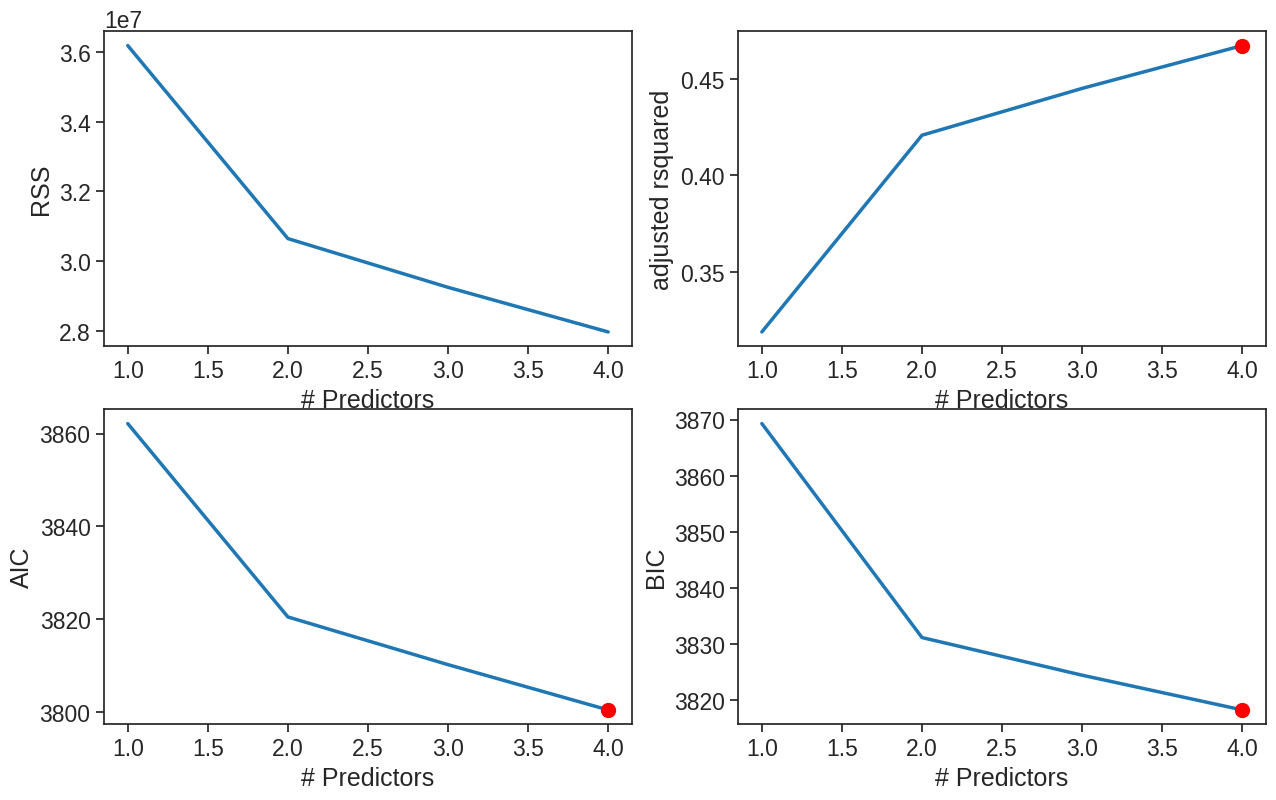

In [48]:
plt.figure(figsize=(15,9))
plt.rcParams.update({'font.size': 14, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
ax = sns.lineplot(x = "kft", y = "rss", data = results)
ax.set_xlabel('# Predictors')
ax.set_ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

results["rsquared_adj"] = results.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
ax = sns.lineplot(x = "kft", y = "rsquared_adj", data = results)
plt.plot(results["rsquared_adj"].argmax()+1, results["rsquared_adj"].max(), "or")
ax.set_xlabel('# Predictors')
ax.set_ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
results["aic"] = results.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
ax = sns.lineplot(x = "kft", y = "aic", data = results)
plt.plot(results["aic"].argmin()+1, results["aic"].min(), "or")
ax.set_xlabel('# Predictors')
ax.set_ylabel('AIC')

results["bic"] = results.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
ax = sns.lineplot(x = "kft", y = "bic", data = results)
plt.plot(results["bic"].argmin()+1, results["bic"].min(), "or")
ax.set_xlabel('# Predictors')
ax.set_ylabel('BIC');

套件 [`mlxtend`](http://rasbt.github.io/mlxtend/) 也可以幫助我們執行特徵選擇，它內部使用交叉驗證來估計所有可能特徵組合的測試誤差，而不是將程序分為兩階段

In [49]:
# Perform an Exhaustive Search. The EFS and SFS packages use 'neg_mean_squared_error'. The 'mean_squared_error' seems to have been deprecated. I think this is just the MSE with the a negative sign.
lr = skl.LinearRegression()
efs1 = EFS(lr,
           min_features=1,
           max_features=4,
           scoring='neg_mean_squared_error',
           print_progress=True,
           n_jobs=-1,
           cv=5) #5-fold

In [50]:
efs1.fit(X, Y)

Features: 5035/5035

ExhaustiveFeatureSelector(estimator=LinearRegression(),
                          feature_groups=[[0], [1], [2], [3], [4], [5], [6],
                                          [7], [8], [9], [10], [11], [12], [13],
                                          [14], [15], [16], [17], [18]],
                          max_features=4, n_jobs=-1,
                          scoring='neg_mean_squared_error')

In [51]:
efs1.best_feature_names_

('AtBat', 'Hits', 'Walks', 'CRBI')

In [52]:
## This is a time consuming process, be careful. You may consider setting --ServerApp.iopub_msg_rate_limit to a larger value or not to execute this cell
r11 = []
sub = []
kft = []
for i in range(1,20):
    efs1 = EFS(lr,
           min_features=i,
           max_features=i,
           #scoring='neg_mean_squared_error', to calculate AIC, BIC you will need rss and the estimation of sigma (also from rss) https://xavierbourretsicotte.github.io/subset_selection.html
           scoring='r2',
           print_progress=True,
           cv = 0, #no CV
           n_jobs=-1) #parallelism
    efs1.fit(X, Y)
    best_score, best_subset = efs1.best_score_, efs1.best_feature_names_

    r11.append(best_score)
    sub.append(best_subset)
    kft.append(i)
    print('Progess: i = {}, done'.format(i))

Features: 19/19

Progess: i = 1, done


Features: 171/171

Progess: i = 2, done


Features: 969/969

Progess: i = 3, done


Features: 3876/3876

Progess: i = 4, done


Features: 11628/11628

Progess: i = 5, done


Features: 27132/27132

Progess: i = 6, done


Features: 50388/50388

Progess: i = 7, done


Features: 75582/75582

Progess: i = 8, done


Features: 92378/92378

Progess: i = 9, done


Features: 92378/92378

Progess: i = 10, done


Features: 75582/75582

Progess: i = 11, done


Features: 50388/50388

Progess: i = 12, done


Features: 27132/27132

Progess: i = 13, done


Features: 11628/11628

Progess: i = 14, done


Features: 3876/3876

Progess: i = 15, done


Features: 969/969

Progess: i = 16, done


Features: 1/1

Progess: i = 17, done
Progess: i = 18, done
Progess: i = 19, done


In [53]:
results2 = pd.DataFrame({'kft': kft, 'r2': r11, 'sub': sub},
                           columns = ['r2', 'sub', 'kft']).set_index('kft')
results2['sub']

,sub
kft,
1,"(CRBI,)"
2,"(Hits, CRBI)"
3,"(Hits, CRBI, PutOuts)"
4,"(Hits, CRBI, Division[W], PutOuts)"
5,"(AtBat, Hits, CRBI, Division[W], PutOuts)"
6,"(AtBat, Hits, Walks, CRBI, Division[W], PutOuts)"
7,"(Hits, Walks, CAtBat, CHits, CHmRun, Division[..."
8,"(AtBat, Hits, Walks, CHmRun, CRuns, CWalks, Di..."
9,"(AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWal..."


In [54]:
def adjust_r2(r2, num_examples, num_features):
    coef = (num_examples - 1) / (num_examples - num_features - 1)
    return 1 - (1 - r2) * coef

In [55]:
adj_r2 = []
for i, r2 in enumerate(r11):
    adj_r2.append(adjust_r2(r2=r2,
                  num_examples=X.shape[0],
                  num_features=i+1))

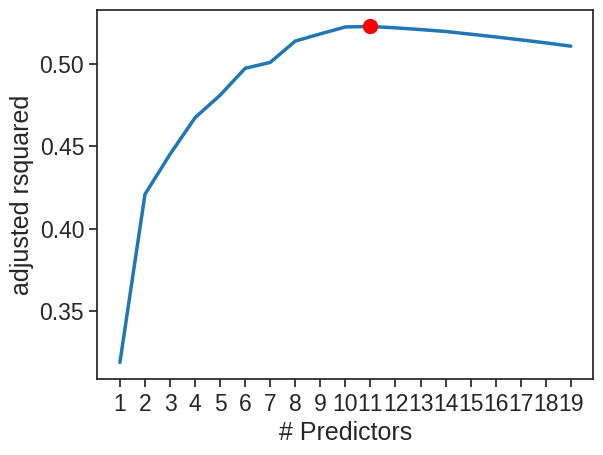

In [56]:
adj_r2 = np.array(adj_r2)
sns.lineplot(x=range(1,20), y=adj_r2)
plt.plot(adj_r2.argmax()+1, adj_r2.max(), "or")
plt.xticks(range(1,20))
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared');

根據調整後的 $R^2$，我們看到十一變數模型是最佳模型。該模型相關的預測變數列於下方。

In [57]:
results2['sub'][11]

('AtBat',
 'Hits',
 'Walks',
 'CAtBat',
 'CRuns',
 'CRBI',
 'CWalks',
 'League[N]',
 'Division[W]',
 'PutOuts',
 'Assists')

## Ridge regression 與 Lasso

我們將使用 `scikit-learn.linear_model` 套件（下面我們簡稱為 `skl`）在 `Hitters` 資料上擬合 ridge 和 lasso 正則化線性模型。我們從在最佳子集回歸上一節中計算的模型矩陣 `X`（不含截距）開始。

### Ridge 回歸

R 中的 **glmnet** 演算法使用循環座標下降法來優化目標函數，而 `scikit-learn` 的 Ridge 回歸使用具有 L2 正則化的線性最小平方法。它們是相當不同的實作，但一般原理是相同的。

**R 中的 glmnet() 函數**優化：
$$ \frac{1}{N}|| X\beta-y||^2_2+\lambda\bigg(\frac{1}{2}(1−\alpha)||\beta||^2_2 \ +\ \alpha||\beta||_1\bigg) $$
（參見 R 文件和 https://cran.r-project.org/web/packages/glmnet/vignettes/glmnet_beta.pdf）<BR>
該函數支援 L1 和 L2 正則化。對於純 Ridge 回歸，我們需要使用 $\alpha = 0$。這將上述成本函數簡化為
$$ \frac{1}{N}|| X\beta-y||^2_2+\frac{1}{2}\lambda ||\beta||^2_2 $$

在 `python` 中，我們也可以在 https://github.com/civisanalytics/python-glmnet 找到類似的函數

另一方面，**scikit-learn 的 Ridge()** 函數優化：
$$ ||X\beta - y||^2_2 + \alpha ||\beta||^2_2 $$
這等同於優化
$$ \frac{1}{N}||X\beta - y||^2_2 + \frac{\alpha}{N} ||\beta||^2_2 $$

我們將使用函數 `skl.ElasticNet()` 來擬合 Ridge 和 Lasso。要擬合 Ridge 回歸模型的*路徑*，我們使用 `skl.ElasticNet.path()`，它可以擬合 Ridge 和 Lasso 以及混合模式；Ridge 回歸對應 `l1_ratio=0`。如果變數以不同單位測量，標準化 `X` 的列是個好做法。由於 `skl.ElasticNet()` 不進行標準化，我們必須自己處理。由於我們先進行標準化，為了在原始尺度上找到係數估計，我們必須*反標準化*係數估計。(6.5) 和 (6.7) 中的參數 $\lambda$ 在 `scikit-learn` 中稱為 `alphas`。為了與本章其餘部分保持一致，我們在下面使用 `lambdas` 而不是 `alphas`。

In [58]:
D = design.fit_transform(Hitters)
D = D.drop('intercept', axis=1)
X = np.asarray(D)

In [114]:
# Numerical unstable
# Xs = X - X.mean(0)[None,:]
# X_scale = X.std(0)
# Xs = Xs / X_scale[None,:]
# lambdas = 10**np.linspace(8, -2, 100) / Y.std()
# soln_array = skl.ElasticNet.path(Xs,
#                                  Y,
#                                  l1_ratio=0.,
#                                  alphas=lambdas)[1]
# soln_array.shape

上述課本提供的數值不穩定，我們建議直接使用Ridge，並且手動選定網格! Ridge 和 ElasticNet 在計算目標函數時，對 alpha (也就是 lambda) 的定義方式不同。注意這邊我們乘上樣本數讓他與ElasticNet一致。但實務上不需要這麼做，讓大家了解這邊得到的結果和課本一致，我們僅在這小節這樣做，之後就用我們自己定義的網格了!

In [119]:
# There is no path for Ridge 迴歸 in sklearn
Xs = X - X.mean(0)[None,:]
X_scale = X.std(0)
Xs = Xs / X_scale[None,:]
lambdas = 10**np.linspace(8, -2, 100) / Y.std()

n_samples = Xs.shape[0]
ridge = skl.Ridge()
coefs = []

for a in lambdas:
    ridge.set_params(alpha = a * n_samples)
    ridge.fit(Xs, Y) # We standardize features before ridge regression
    coefs.append(ridge.coef_)

soln_array = np.array(coefs)

這裡我們提取沿著正則化路徑對應解的係數陣列。預設情況下，除了 `l1_ratio=0` 的情況（這裡是 Ridge 回歸），`skl.ElasticNet.path` 方法會在自動選擇的 $\lambda$ 值範圍內擬合路徑。原因相當技術性；對於除 Ridge 外的所有模型，我們可以找到使所有係數為零的最小 $\lambda$ 值。對於 Ridge，這個值是 $\infty$。因此這裡我們選擇在網格值範圍從 $\lambda=10^{8}$ 到 $\lambda=10^{-2}$（按 $y$ 的標準差縮放）上實作函數，基本上涵蓋了從僅包含截距的空模型到最小平方擬合的完整情境範圍。

與每個 $\lambda$ 值相關的是 Ridge 回歸係數向量，可以通過 `soln_array` 的列來存取。在這個情況下，`soln_array` 是一個 $19 \times 100$ 矩陣，有 19 行（每個預測變數一行）和 100 列（每個 $\lambda$ 值一列）。

我們轉置這個矩陣並將其轉換為資料表以便於查看和繪圖。

In [121]:
soln_path = pd.DataFrame(soln_array,
                         columns=D.columns,
                         index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League[N],Division[W],PutOuts,Assists,Errors,NewLeague[N]
negative log(lambda),,,,,,,,,,,,,,,,,,,
-12.310855,0.000800,0.000889,0.000695,0.000851,0.000911,0.000900,0.000812,0.001067,0.001113,0.001064,0.001141,0.001149,0.000993,-0.000029,-0.000390,0.000609,0.000052,-0.000011,-0.000006
-12.078271,0.001010,0.001122,0.000878,0.001074,0.001150,0.001135,0.001025,0.001346,0.001404,0.001343,0.001439,0.001450,0.001253,-0.000037,-0.000492,0.000769,0.000065,-0.000014,-0.000007
-11.845686,0.001274,0.001416,0.001107,0.001355,0.001451,0.001433,0.001293,0.001698,0.001772,0.001694,0.001816,0.001830,0.001581,-0.000046,-0.000621,0.000970,0.000082,-0.000017,-0.000009
-11.613102,0.001608,0.001787,0.001397,0.001710,0.001831,0.001808,0.001632,0.002143,0.002236,0.002138,0.002292,0.002309,0.001995,-0.000058,-0.000784,0.001224,0.000104,-0.000022,-0.000012
-11.380518,0.002029,0.002255,0.001763,0.002158,0.002310,0.002281,0.002059,0.002704,0.002821,0.002698,0.002892,0.002914,0.002517,-0.000073,-0.000990,0.001544,0.000131,-0.000028,-0.000015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.784658,-290.835201,336.946220,37.325857,-59.755827,-26.509406,134.858901,-17.223156,-387.685174,89.447736,-12.297041,476.117985,257.305580,-213.137544,31.257121,-58.457974,78.761614,53.620140,-22.207562,-12.401843
10.017243,-290.888505,337.127132,37.434004,-59.922876,-26.608885,134.903013,-17.113754,-388.383763,88.896737,-12.680608,477.063484,257.995250,-213.291441,31.255531,-58.448944,78.761527,53.643522,-22.198062,-12.391101
10.249827,-290.930926,337.271434,37.520226,-60.056140,-26.688192,134.938152,-17.026850,-388.936485,88.452215,-12.987323,477.818285,258.546406,-213.414386,31.254219,-58.441758,78.761465,53.662029,-22.190465,-12.382493


我們繪製路徑來了解係數如何隨 $\lambda$ 變化。為了控制圖例位置，我們首先在繪圖方法中將 `legend` 設為 `False`，然後用 `ax` 的 `legend()` 方法添加它。

<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-3327353287.py:3: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$-\log(\lambda)$', fontsize=20)


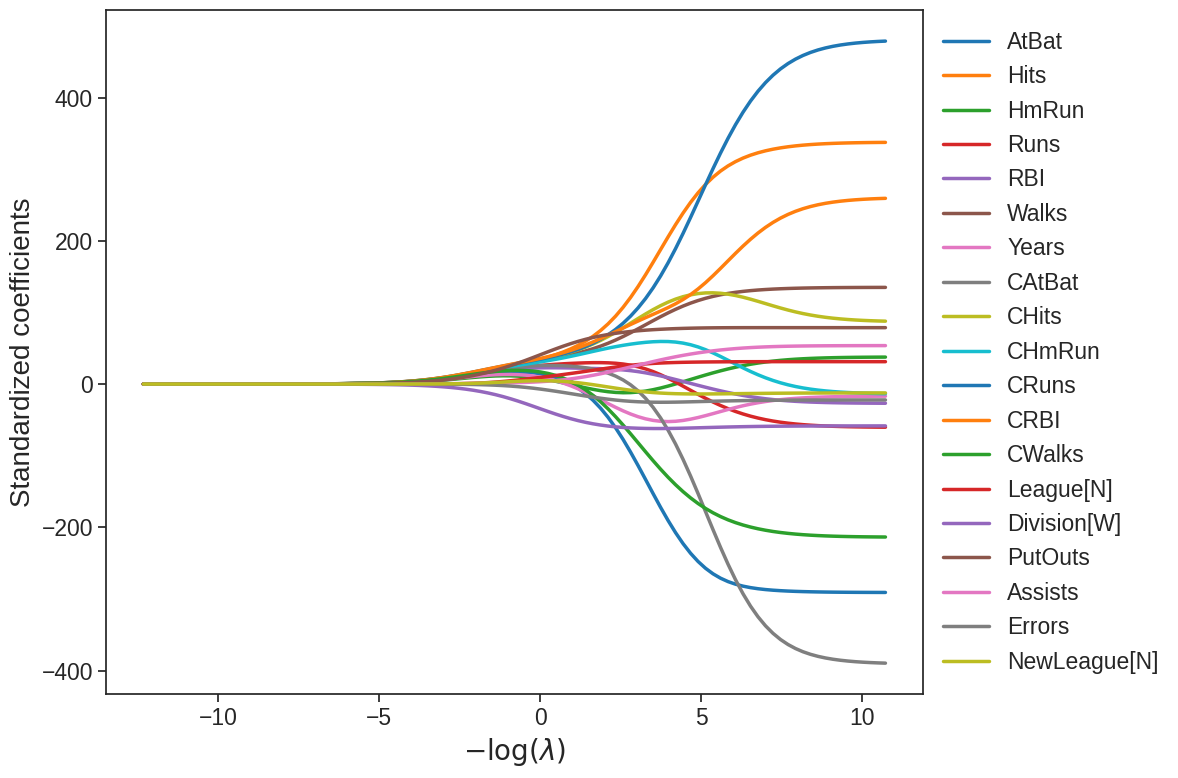

In [122]:
path_fig, ax = subplots(figsize=(12,8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
path_fig.tight_layout();  # Ensure that elements of the figure do not overlap

（我們在水平標籤中使用了 `latex` 格式化，以便適當格式化希臘字母 $\lambda$。）我們預期當使用大的 $\lambda$ 值時，就 $\ell_2$ 範數而言，係數估計會比使用小 $\lambda$ 值時小得多。（回憶 $\ell_2$ 範數是係數值平方和的平方根。）我們顯示第 40 步的係數，其中 $\lambda$ 是 25.535。

In [123]:
beta_hat = soln_path.loc[soln_path.index[39]]
lambdas[39], beta_hat

(np.float64(25.53538897200662),
 AtBat           5.433750
 Hits            6.223582
 HmRun           4.585498
 Runs            5.880855
 RBI             6.195921
 Walks           6.277975
 Years           5.299767
 CAtBat          7.147501
 CHits           7.539495
 CHmRun          7.182344
 CRuns           7.728649
 CRBI            7.790702
 CWalks          6.592901
 League[N]       0.042445
 Division[W]    -3.107159
 PutOuts         4.605263
 Assists         0.378371
 Errors         -0.135196
 NewLeague[N]    0.150323
 Name: -3.240065292879872, dtype: float64)

讓我們計算標準化係數的 $\ell_2$ 範數。

In [124]:
np.linalg.norm(beta_hat)

np.float64(24.170617201443775)

相比之下，這裡是當 $\lambda$ 是 2.44e-01 時的 $\ell_2$ 範數。注意與這個較小 $\lambda$ 值相關的係數有更大的 $\ell_2$ 範數。

In [125]:
beta_hat = soln_path.loc[soln_path.index[59]]
lambdas[59], np.linalg.norm(beta_hat)

(np.float64(0.24374766133488554), np.float64(160.42371017725918))

上面我們預先標準化了 `X`，並使用 `Xs` 擬合 Ridge 模型。`scikit-learn` 中的 `Pipeline()` 物件提供了一個清晰的方式來將特徵標準化與擬合 Ridge 模型本身分離。

In [128]:
#ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0)
ridge = skl.Ridge(alpha=lambdas[59]* n_samples)
scaler = StandardScaler(with_mean=True,  with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
pipe.fit(X, Y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', Ridge(alpha=np.float64(64.1056349310749)))])

我們展示它給出與我們之前在標準化資料上的擬合相同的 $\ell_2$ 範數。

In [129]:
np.linalg.norm(ridge.coef_)

np.float64(160.42371017725918)

注意上面的 `pipe.fit(X, Y)` 操作已經改變了 `ridge` 物件，特別是添加了之前不存在的屬性，如 `coef_`。

### 用交叉驗證估計 Ridge 回歸的測試錯誤

事先為 Ridge 回歸選擇 $\lambda$ 值是困難的，如果不是不可能的話。我們將想要使用驗證方法或交叉驗證來選擇調優參數。讀者可能不會驚訝 `Pipeline()` 方法可以在 `skm.cross_validate()` 中與驗證方法（即 `validation`）或 $k$ 摺交叉驗證一起使用。

我們固定分割器的隨機狀態，以便獲得的結果將是可重現的。注意這邊我們不再調整$\lambda$了!

In [131]:
# This is basically the same as train_test_split
validation = skm.ShuffleSplit(n_splits=1,
                              test_size=0.5,
                              random_state=0)
pipe['ridge'].alpha = 0.01
results = skm.cross_validate(pipe,
                             X,
                             Y,
                             scoring='neg_mean_squared_error',
                             cv=validation)
-results['test_score']

array([133821.45286659])

測試 MSE 是 1.338e+05。注意如果我們只是擬合一個只有截距的模型，我們會使用訓練觀測值的平均值來預測每個測試觀測值。我們可以通過擬合具有*非常*大的 $\lambda$ 值的 Ridge 回歸模型來得到相同的結果。注意：`1e10` 表示 $10^{10}$。

In [69]:
pipe['ridge'].alpha  = 1e10
results = skm.cross_validate(pipe,
                             X,
                             Y,
                             scoring='neg_mean_squared_error',
                             cv=validation)
-results['test_score']

array([231853.39632821])

顯然選擇 $\lambda=0.01$ 是任意的，所以我們將使用交叉驗證或驗證集方法來選擇調優參數 $\lambda$。物件 `GridSearchCV()` 允許窮舉網格搜尋來選擇這樣的參數。

我們首先使用驗證集方法來選擇 $\lambda$。

In [70]:
param_grid = {'ridge__alpha': lambdas}
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=validation,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', Ridge(alpha=np.float64(0.7798138828236654)))])

或者，我們可以使用 5 摺交叉驗證。

In [71]:
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', Ridge(alpha=np.float64(2.494832928915928)))])

我們現在繪製交叉驗證的 MSE 作為 $-\log(\lambda)$ 的函數，其中收縮從左到右遞減。

<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-2490229730.py:6: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$-\log(\lambda)$', fontsize=20)


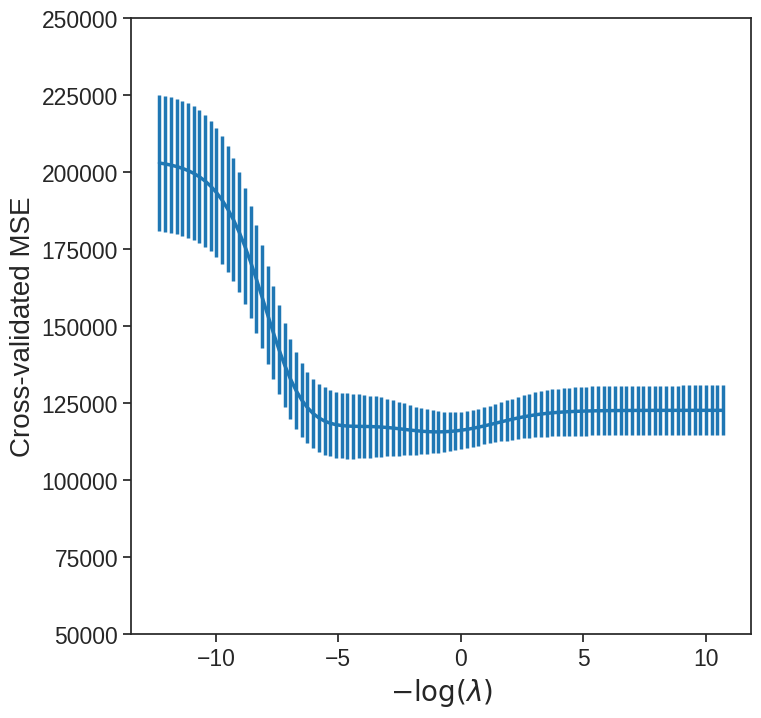

In [72]:
ridge_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            -grid.cv_results_['mean_test_score'],
            yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylim([50000,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

我們可以交叉驗證不同的指標來選擇參數。`skl.ElasticNet()/skl.Ridge()` 的預設指標是測試 $R^2$。讓我們在這裡比較交叉驗證的 $R^2$ 和 MSE。

In [73]:
grid_r2 = skm.GridSearchCV(pipe,
                           param_grid,
                           cv=kfold)
grid_r2.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge', Ridge(alpha=10000000000.0))]),
             param_grid={'ridge__alpha': array([2.22093791e+05, 1.76005531e+05, 1.39481373e+05, 1.10536603e+05,
       8.75983676e+04, 6.94202082e+04, 5.50143278e+04, 4.35979140e+04,
       3.45506012e+04, 2.73807606e+04, 2.16987845e...
       4.67486141e-03, 3.70474772e-03, 2.93594921e-03, 2.32668954e-03,
       1.84386167e-03, 1.46122884e-03, 1.15799887e-03, 9.17694298e-04,
       7.27257037e-04, 5.76338765e-04, 4.56738615e-04, 3.61957541e-04,
       2.86845161e-04, 2.27319885e-04, 1.80147121e-04, 1.42763513e-04,
       1.13137642e-04, 8.96596467e-05, 7.10537367e-05, 5.63088712e-05,
       4.46238174e-05, 3.53636122e-05, 2.80250579e-05, 2.22093791e-05])})

最後，讓我們繪製交叉驗證的 $R^2$ 結果。

<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-2309042680.py:5: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$-\log(\lambda)$', fontsize=20)


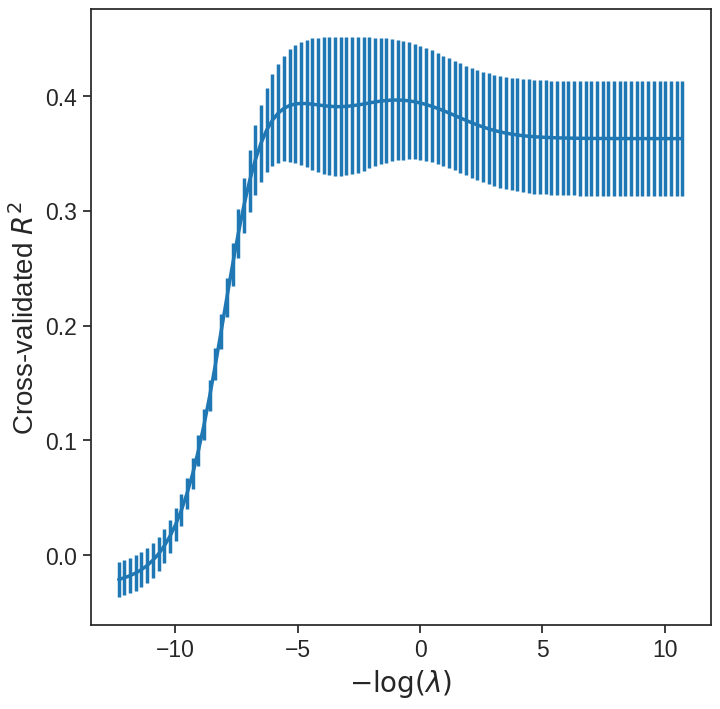

In [74]:
r2_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            grid_r2.cv_results_['mean_test_score'],
            yerr=grid_r2.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated $R^2$', fontsize=20);

### 介紹 RidgeCV 以及相關函數

Ridge、Lasso 和 Elastic Net 可以沿著 $\lambda$ 值序列有效擬合，創建所謂的*解路徑*或*正則化路徑*。因此有專門的 RidegCV 或 LassoCV 來擬合這樣的路徑，並使用交叉驗證選擇合適的 $\lambda$ 值。

In [75]:
# ridgeCV = skl.ElasticNetCV(alphas=lambdas,
#                            l1_ratio=0,
#                            cv=kfold)
# pipeCV = Pipeline(steps=[('scaler', scaler),
#                          ('ridge', ridgeCV)])
# pipeCV.fit(X, Y)

In [76]:
ridgeCV = skl.RidgeCV(alphas=lambdas,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)])
pipeCV.fit(X, Y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 RidgeCV(alphas=array([2.22093791e+05, 1.76005531e+05, 1.39481373e+05, 1.10536603e+05,
       8.75983676e+04, 6.94202082e+04, 5.50143278e+04, 4.35979140e+04,
       3.45506012e+04, 2.73807606e+04, 2.16987845e+04, 1.71959156e+04,
       1.36274691e+04, 1.07995362e+04, 8.55844774e+03, 6.78242347e+03,
       5.37495461e+03, 4.25955961e+03, 3.375...
       1.84386167e-03, 1.46122884e-03, 1.15799887e-03, 9.17694298e-04,
       7.27257037e-04, 5.76338765e-04, 4.56738615e-04, 3.61957541e-04,
       2.86845161e-04, 2.27319885e-04, 1.80147121e-04, 1.42763513e-04,
       1.13137642e-04, 8.96596467e-05, 7.10537367e-05, 5.63088712e-05,
       4.46238174e-05, 3.53636122e-05, 2.80250579e-05, 2.22093791e-05]),
                         cv=KFold(n_splits=5, random_state=0, shuffle=True)))])

In [77]:
tuned_ridge = pipeCV.named_steps['ridge']
tuned_ridge

RidgeCV(alphas=array([2.22093791e+05, 1.76005531e+05, 1.39481373e+05, 1.10536603e+05,
       8.75983676e+04, 6.94202082e+04, 5.50143278e+04, 4.35979140e+04,
       3.45506012e+04, 2.73807606e+04, 2.16987845e+04, 1.71959156e+04,
       1.36274691e+04, 1.07995362e+04, 8.55844774e+03, 6.78242347e+03,
       5.37495461e+03, 4.25955961e+03, 3.37562814e+03, 2.67512757e+03,
       2.11999285e+03, 1.68005808e+0...
       1.84386167e-03, 1.46122884e-03, 1.15799887e-03, 9.17694298e-04,
       7.27257037e-04, 5.76338765e-04, 4.56738615e-04, 3.61957541e-04,
       2.86845161e-04, 2.27319885e-04, 1.80147121e-04, 1.42763513e-04,
       1.13137642e-04, 8.96596467e-05, 7.10537367e-05, 5.63088712e-05,
       4.46238174e-05, 3.53636122e-05, 2.80250579e-05, 2.22093791e-05]),
        cv=KFold(n_splits=5, random_state=0, shuffle=True))

In [78]:
tuned_ridge.alpha_

np.float64(2.494832928915928)

In [92]:
# tuned_ridge = pipeCV.named_steps['ridge']
# ridgeCV_fig, ax = subplots(figsize=(8,8))
# ax.errorbar(-np.log(lambdas),
#             tuned_ridge.mse_path_.mean(1),
#             yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(K))
# ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
# ax.set_ylim([50000,250000])
# ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
# ax.set_ylabel('Cross-validated MSE', fontsize=20);


我們看到導致最小交叉驗證誤差的 $\lambda$ 值是 2.495，可作為 `tuned_ridge.alpha_` 的值獲得。與這個 $\lambda$ 值相關的測試 MSE 是多少？

In [79]:
# np.min(tuned_ridge.mse_path_.mean(1))
model = skl.Ridge()
model.set_params(alpha=tuned_ridge.alpha_)
model.fit(Xs, Y)
metrics.mean_squared_error(model.predict(Xs), Y)

93391.76013626697

最後，`tuned_ridge.coef_` 在這個 $\lambda$ 值下在整個資料集上擬合的係數。

In [80]:
tuned_ridge.coef_

array([-235.72497905,  253.05642833,    6.24782371,   -8.44450763,
          1.04320683,  112.84181561,  -49.11587947, -127.34656694,
        124.49712479,   55.04269704,  231.62603982,  124.6086533 ,
       -158.60546327,   30.55498489,  -61.37429494,   78.0012172 ,
         41.81539953,  -24.78446896,  -13.80530157])

如預期的那樣，沒有任何係數是零——Ridge 回歸不執行變數選擇！

### 用雙層迴圈嚴謹計算交叉驗證 Ridge 的測試誤差

使用交叉驗證選擇 $\lambda$ 提供單一回歸估計器，類似於我們在第 3 章中看到的擬合線性回歸模型。因此合理估計其測試誤差是什麼。我們在這裡遇到的問題是，交叉驗證在選擇 $\lambda$ 時已經*觸及*了所有資料，因此我們沒有進一步的資料來估計測試誤差。

折衷方案是對資料進行初始分割成兩個不相交的集合：訓練集和測試集。然後我們在訓練集上擬合交叉驗證調優的 Ridge 回歸，並在測試集上評估其性能。

In [133]:
# 內層 CV 它將用於在訓練集上尋找最佳 alpha
inner_cv = skm.KFold(n_splits=5,
                     shuffle=True,
                     random_state=2)
# 步驟 1：一次性將資料分成訓練集 (train) 與測試集 (test)
X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    test_size=0.25,
    random_state=1 # 使用相同的 random_state 確保切分結果一致
)

# 步驟 2：建立 Pipeline，並在「訓練集」上進行交叉驗證以尋找最佳 alpha
# 注意：RidgeCV 現在只會在 X_train, Y_train 上運作
ridgeCV = skl.RidgeCV(alphas=lambdas,
                      cv=inner_cv)

pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)])

# 在訓練集上擬合模型。pipeCV 會自動完成所有事情：
# 1. scaler 在 X_train 上 fit_transform
# 2. ridgeCV 在縮放後的 X_train 上，用 inner_cv 找到最佳 alpha
# 3. 用找到的最佳 alpha，在「整個」縮放後的 X_train 上重新訓練一個最終的 Ridge 模型
print("Fitting the model on the training data...")
pipeCV.fit(X_train, Y_train)
print("Fit complete.")

# 步驟 3：用訓練好的 Pipeline 在「測試集」上進行最終評估
print(f"The best alpha found on the training set was: {pipeCV.named_steps['ridge'].alpha_}")

# 使用 .predict() 來取得預測值，並計算 MSE
Y_pred = pipeCV.predict(X_test)
final_mse = mean_squared_error(Y_test, Y_pred)

print(f"Final score (MSE) on the test set: {final_mse}")

Fitting the model on the training data...
Fit complete.
The best alpha found on the training set was: 207.12541271401545
Final score (MSE) on the test set: 132744.6447165926


我們可以進一步改進成巢狀的交叉驗證。下面，我們使用 75% 用於訓練，25% 用於測試，估計器是使用 5 摺交叉驗證調優的 Ridge 回歸。這可以通過以下程式碼實現：

In [134]:
outer_valid = skm.ShuffleSplit(n_splits=1,
                               test_size=0.25,
                               random_state=1)
inner_cv = skm.KFold(n_splits=5,
                     shuffle=True,
                     random_state=2)
# ridgeCV = skl.ElasticNetCV(alphas=lambdas,
#                            l1_ratio=0,
#                            cv=inner_cv)
ridgeCV = skl.RidgeCV(alphas=lambdas,
                           cv=inner_cv)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)]);

results = skm.cross_validate(pipeCV,
                             X,
                             Y,
                             cv=outer_valid,
                             scoring='neg_mean_squared_error')
-results['test_score']

array([132744.64471659])

這嚴格來說，它是一個「單次驗證」(single validation)，而不是一個更穩健的 K-摺交叉驗證。大家可以試著把外層也改成K-摺試看看!



In [137]:
# 將 outer_valid 從 ShuffleSplit 改成 KFold
# n_splits=5 表示執行 5 次外層迴圈，得到 5 個分數
# shuffle=True 表示在切分前會先將資料隨機排序，這在實務上很重要
outer_valid = skm.KFold(n_splits=5,
                    shuffle=True,
                    random_state=1)

# 其餘程式碼完全不變
inner_cv = skm.KFold(n_splits=5,
                     shuffle=True,
                     random_state=2)

ridgeCV = skl.RidgeCV(alphas=lambdas,
                      cv=inner_cv) # 確保內外層評分標準一致

pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)])

# 執行完整的巢狀交叉驗證
results = skm.cross_validate(pipeCV,
                             X,
                             Y,
                             cv=outer_valid, # <-- 使用新的 KFold 物件
                             scoring='neg_mean_squared_error')

# 現在 results['test_score'] 會是一個包含 5 個分數的陣列
scores = -results['test_score']
print(f"每一摺的分數: {scores}")
print(f"平均分數: {np.mean(scores)}")
print(f"分數標準差: {np.std(scores)}")

每一摺的分數: [138050.6453072   65041.64655894 170180.08043541 118457.82569083
  96470.04535738]
平均分數: 117640.04866995159
分數標準差: 35756.05430453973


### Lasso

我們看到在 `Hitters` 資料集上，Ridge 回歸適當選擇 $\lambda$ 可以勝過最小平方和虛無模型。我們現在詢問 Lasso 是否能產生比 Ridge 回歸更準確或更可解釋的模型。為了配適 Lasso 模型，我們再次使用 `ElasticNetCV()` 函數；然而，這次我們使用參數 `l1_ratio=1`。除了這個變化外，我們的步驟與配適 Ridge 模型時完全相同。

In [83]:
lassoCV = skl.ElasticNetCV(n_alphas=100,
                           l1_ratio=1,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

np.float64(3.1472370031649866)

In [84]:
lambdas, soln_array = skl.Lasso.path(Xs,
                                     Y,
                                     l1_ratio=1,
                                     n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))

In [ ]:
# You can also use a custom values for lambda can also be used like in the case of ridge 迴歸

# alphas = 10**np.linspace(10,-2,100)
# lasso = Lasso(max_iter=10000)
# coefs = []

# for a in alphas:
#     lasso.set_params(alpha=a)
#     lasso.fit(scale(X_train), y_train)
#     coefs.append(lasso.coef_)

# ax = plt.gca()
# ax.plot(alphas, coefs)
# ax.set_xscale('log')
# ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
# plt.axis('tight')
# plt.xlabel('alpha')
# plt.ylabel('weights')
# plt.title('Lasso coefficients as a function of the regularization');

我們可以從標準化係數的係數圖中看到，根據調整參數的選擇，某些係數將完全等於零。

<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-884455879.py:3: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$-\log(\lambda)$', fontsize=20)


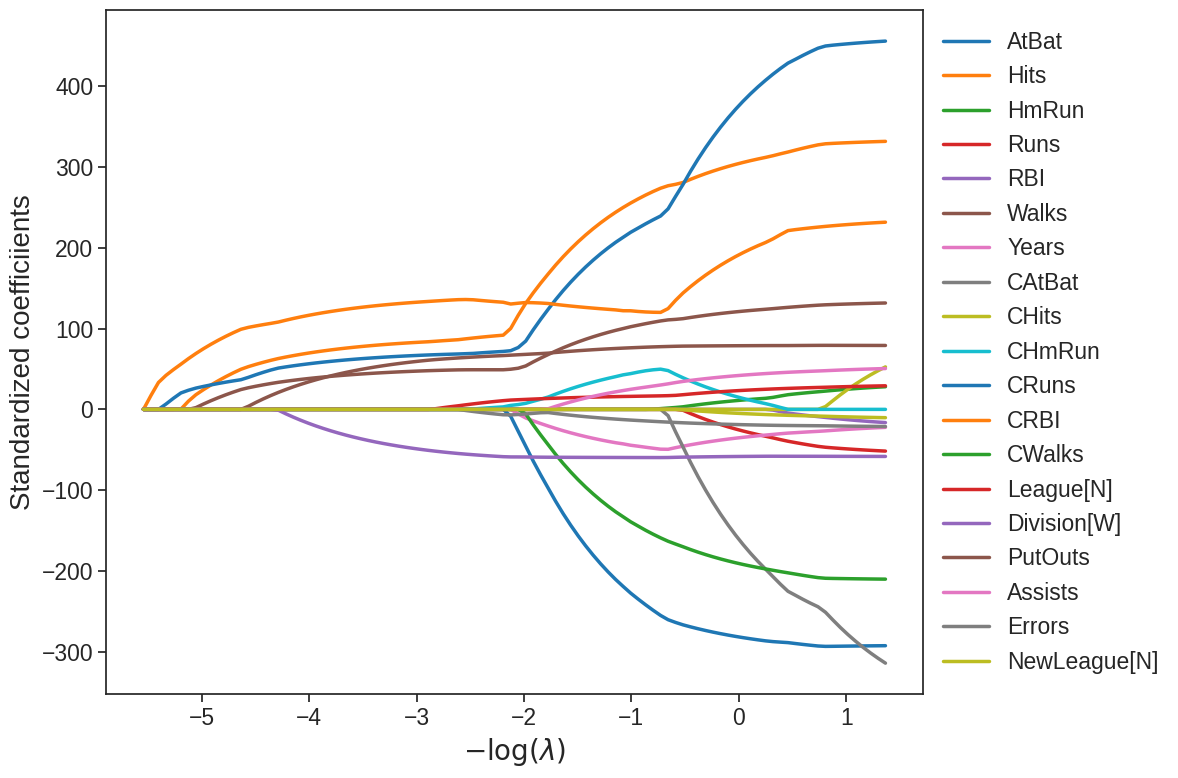

In [85]:
path_fig, ax = subplots(figsize=(12,8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
path_fig.tight_layout();  # Ensure that elements of the figure do not overlap

最小交叉驗證錯誤低於虛無模型和最小平方的測試集 MSE，且與 Ridge 回歸的測試 MSE 非常相似，該 $\lambda$ 是通過交叉驗證選擇的。

In [86]:
np.min(tuned_lasso.mse_path_.mean(1))

np.float64(114690.73118253677)

讓我們再次產生交叉驗證錯誤的圖。

<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-3184589275.py:7: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$-\log(\lambda)$', fontsize=20)


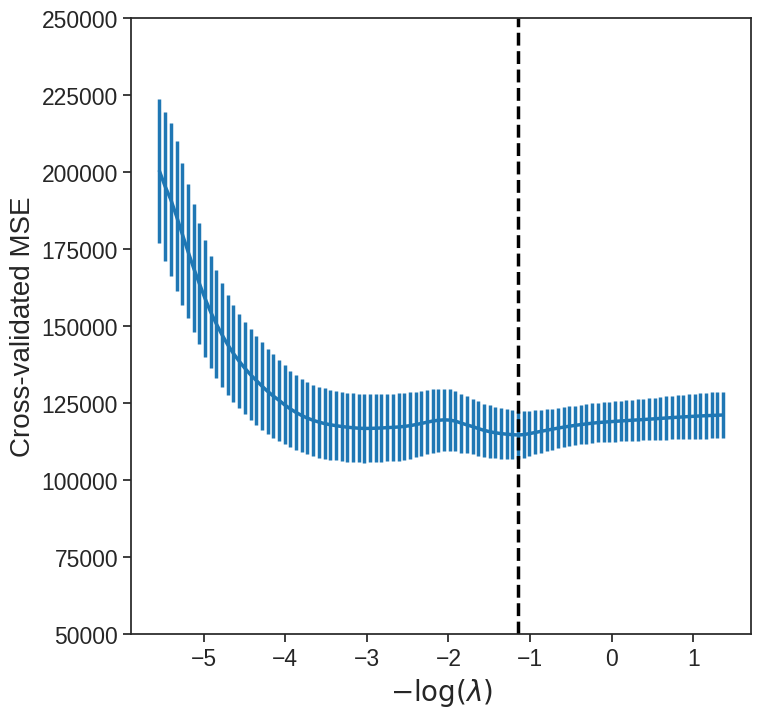

In [87]:
lassoCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_ylim([50000,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

然而，Lasso 相對於 Ridge 回歸有一個實質優勢，即得到的係數估計是稀疏的。這裡我們看到 19 個係數估計中有 6 個完全為零。因此由交叉驗證選擇 $\lambda$ 的 Lasso 模型只包含 13 個變數。

In [88]:
tuned_lasso.coef_

array([-210.01008773,  243.4550306 ,    0.        ,    0.        ,
          0.        ,   97.69397357,  -41.52283116,   -0.        ,
          0.        ,   39.62298193,  205.75273856,  124.55456561,
       -126.29986768,   15.70262427,  -59.50157967,   75.24590036,
         21.62698014,  -12.04423675,   -0.        ])

如同 Ridge 回歸，我們可以透過首先分割為測試集和訓練集，然後在訓練集上內部執行交叉驗證來評估交叉驗證 Lasso 的測試錯誤。我們將此留作練習。

另一種方法是使用 [LassoCV](https://scikit-learn.org/stable/modules/generated/scikit-learn.linear_model.LassoCV.html)，它有相同的用法。

## PCR 與 PLS 回歸

### 主成分回歸

主成分回歸 (PCR) 可以使用 `scikit-learn.decomposition` 模組中的 `PCA()` 來執行。我們現在將 PCR 應用於 `Hitters` 資料，以預測 `Salary`。同樣，請確保已從資料中移除缺失值，如第 6.5.1 節所述。

我們在這裡使用 `LinearRegression()` 來擬合回歸模型。注意：它預設擬合截距，與之前在第 6.5.1 節中看到的 `OLS()` 函數不同。

In [109]:
pca = PCA(n_components=2)
linreg = skl.LinearRegression()
pipe = Pipeline([('pca', pca),
                 ('linreg', linreg)])
pipe.fit(X, Y)
pipe.named_steps['linreg'].coef_

array([0.09846131, 0.4758765 ])

執行 PCA 時，結果會因資料是否已*標準化*而有所不同。如同先前的範例，這可以透過在管線中包含額外的步驟來完成。

In [110]:
pipe = Pipeline([('scaler', scaler),
                 ('pca', pca),
                 ('linreg', linreg)])
pipe.fit(X, Y)
pipe.named_steps['linreg'].coef_

array([106.36859204,  21.60350456])

我們當然可以透過在此情況下使用 `skm.GridSearchCV` 來使用 CV 選擇成分數，固定要變化的參數為 `n_components`。

In [111]:
param_grid = {'pca__n_components': range(1, 20)}
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

讓我們如同其他方法一樣繪製結果。

Optimal number of components: 17


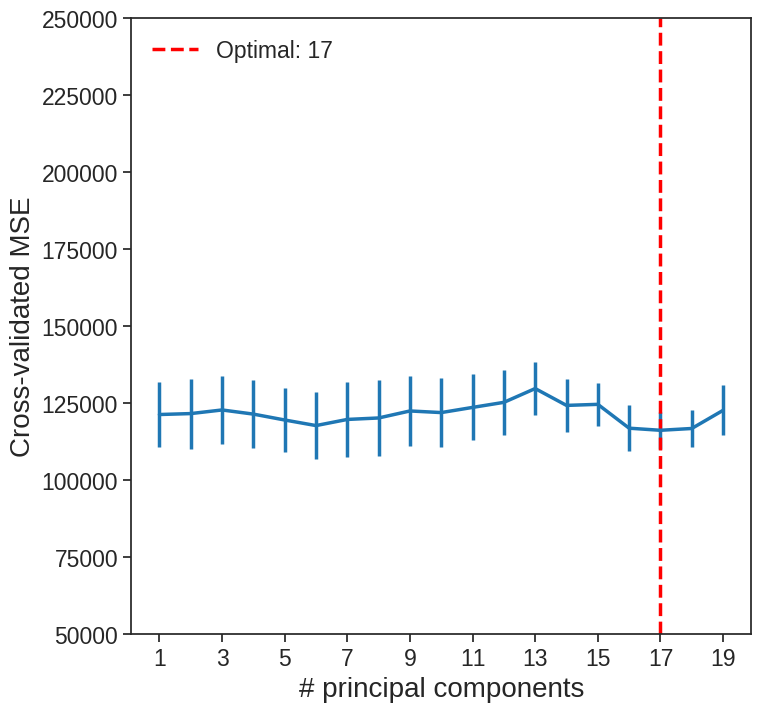

In [112]:
pcr_fig, ax = subplots(figsize=(8,8))
n_comp = param_grid['pca__n_components']
ax.errorbar(n_comp,
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2])
ax.set_ylim([50000,250000]);

# 1. 找出最佳主成分的數量
best_n_comp = n_comp[np.argmin(-grid.cv_results_['mean_test_score'])]

# 2. 畫垂直線標示，並將數值加入圖例中
ax.axvline(best_n_comp, linestyle='--', color='r', label=f'Optimal: {best_n_comp}')
ax.legend() # 顯示圖例

# 3. 在下方印出數值
print(f'Optimal number of components: {best_n_comp}')

我們看到當使用 17 個成分時，交叉驗證錯誤最小。然而，從圖中我們也看到，當模型中只包含一個成分時，交叉驗證錯誤大致相同。這表示使用少數成分的模型可能就足夠了。

從 1 到 19（含）每個可能的成分數都提供了 CV 分數。如果我們嘗試用 `n_components=0` 擬合僅截距的模型，`PCA()` 方法會報錯，所以我們也為這些分割計算僅虛無模型的 MSE。

In [97]:
Xn = np.zeros((X.shape[0], 1))
cv_null = skm.cross_validate(linreg,
                             Xn,
                             Y,
                             cv=kfold,
                             scoring='neg_mean_squared_error')
-cv_null['test_score'].mean()

np.float64(204139.30692994667)

我們 `PCA` 物件的 `explained_variance_ratio_` 屬性提供了使用不同成分數量在預測變數和反應變數中*解釋的變異數百分比*。這個概念在第 12.2 節中有更詳細的討論。

In [98]:
pipe.named_steps['pca'].explained_variance_ratio_

array([0.3831424 , 0.21841076])

簡而言之，我們可以將此視為使用 $M$ 個主成分捕獲的預測變數資訊量。例如，設定 $M=1$ 只捕獲 38.31% 的變異數，而 $M=2$ 額外捕獲 21.84%，總共 60.15% 的變異數。到 $M=6$ 時增加到 88.63%。超過這個點，增量繼續減少，直到我們使用所有 $M=p=19$ 個成分，這捕獲了 100% 的變異數。

### 偏最小平方法

偏最小平方法 (PLS) 在 `PLSRegression()` 函數中實作。

In [99]:
pls = PLSRegression(n_components=2,
                    scale=True) # Scaling here
pls.fit(X, Y)

PLSRegression()

如同 PCR 的情況，我們會想要使用 CV 來選擇成分數量。

In [100]:
param_grid = {'n_components':range(1, 20)}
grid = skm.GridSearchCV(pls,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=PLSRegression(),
             param_grid={'n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

如同我們的其他方法，我們繪製 MSE。

Optimal number of components: 12


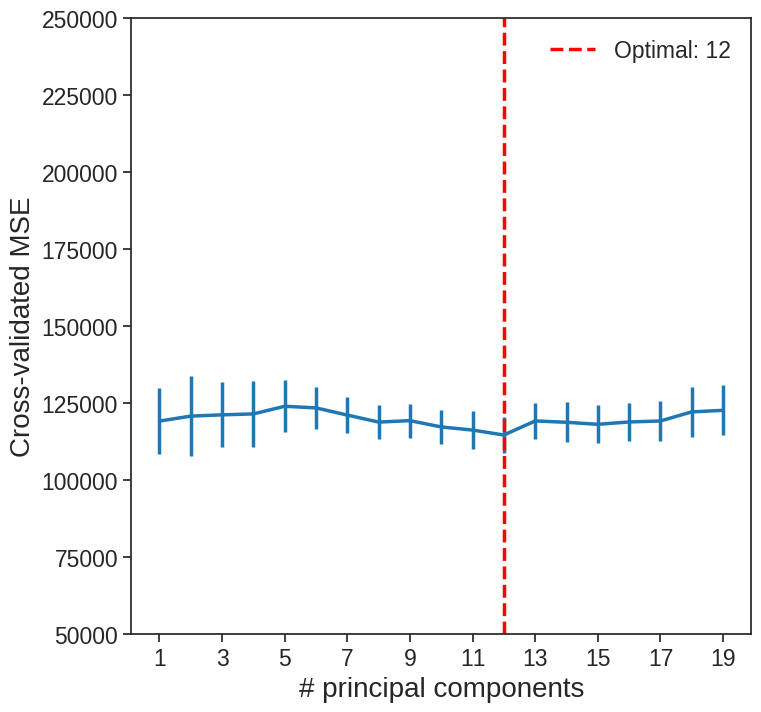

In [107]:
pls_fig, ax = subplots(figsize=(8,8))
n_comp = param_grid['n_components']
ax.errorbar(n_comp,
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2])
ax.set_ylim([50000,250000]);
# 1. 找出最佳主成分的數量
best_n_comp = n_comp[np.argmin(-grid.cv_results_['mean_test_score'])]

# 2. 畫垂直線標示，並將數值加入圖例中
ax.axvline(best_n_comp, linestyle='--', color='r', label=f'Optimal: {best_n_comp}')
ax.legend() # 顯示圖例

# 3. 在下方印出數值
print(f'Optimal number of components: {best_n_comp}')

CV 錯誤在 12 時最小化，儘管此點與較低數量如 2 或 3 個成分之間幾乎沒有明顯差異。